In [1]:
import tensorflow as tf 
import numpy as np
import PIL
import PIL.Image
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

2023-07-06 10:59:50.402696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-07-06 10:59:57.879711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-06 10:59:57.883292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-06 10:59:57.883438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

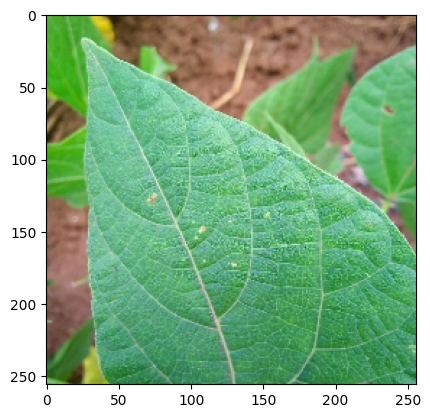

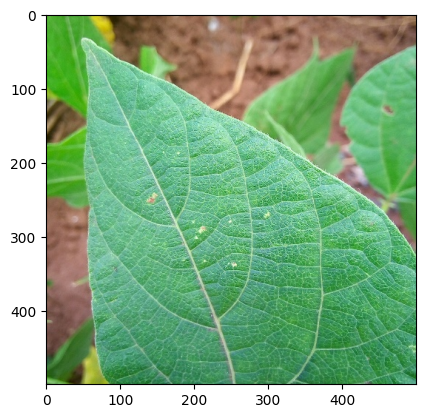

In [2]:
# loading the dataset
def bean_img_iter(bs = 32):
    img_size = (500, 500)
    
    dataset = tfds.load("beans", split='train', shuffle_files=True)
    dataset = dataset.batch(bs, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return iter(dataset)

dsIter = bean_img_iter(8)
ds = next(dsIter)
dsImages = tf.image.resize(ds['image'], (256, 256)) 

plt.imshow(tf.cast(dsImages[1], dtype=tf.uint8))
plt.show()

plt.imshow(ds['image'][1])
plt.show()



In [4]:
import concept_gated_conv

<function matplotlib.pyplot.show(close=None, block=None)>

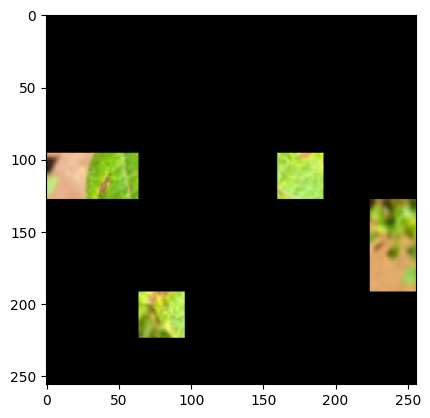

In [174]:
def masking_img(imgs, split=(8,8), masking_ratio = 0.9):
    totalIndexNo = split[0] * split[1]
    candidateNo = int(totalIndexNo * (1 - masking_ratio))
    h_size = imgs.shape[1] // split[0]
    w_size = imgs.shape[2] // split[1]
    
    def gen_mask():
        mask = np.zeros([imgs.shape[1], imgs.shape[2]])
        patch_index = tf.random.shuffle([i for i in range(totalIndexNo)])[:candidateNo]
        
        for n in patch_index:
            x = (n // split[0]) * h_size
            y = (n % split[1]) * w_size
            mask[int(x):int(x + h_size), int(y):int(y+ w_size)] = 1
        np.reshape(mask, [imgs.shape[1], imgs.shape[2], 1])
        return np.reshape(mask, [imgs.shape[1], imgs.shape[2], 1])
    
    masks = tf.map_fn(lambda x: gen_mask(), tf.ones([imgs.shape[0]]))
    return masks


ds = tf.image.resize(next(dsIter)['image'], (256, 256)) 

# augmentation
ds = tf.keras.layers.RandomFlip("horizontal_and_vertical")(ds)
ds = tf.keras.layers.RandomRotation(0.2)(ds)
ds = tf.keras.layers.RandomBrightness(factor=0.2)(ds)
ds = tf.keras.layers.RandomContrast(.2)(ds)
# ds = tf.keras.layers.RandomTranslation((.2), (.2))(ds)
ds = tf.keras.layers.RandomZoom((.6), (.6))(ds)

# mask
# print(ds.shape)
masks = tf.cast(masking_img(ds),tf.float32)
ds = tf.cast(ds,tf.float32)
ds *= masks

plt.imshow(tf.cast(ds[0],tf.uint8))
plt.show

In [4]:
# cgae = concept_gated_conv.concept_gated_conv_ae()
# opt = tf.keras.optimizers.AdamW(learning_rate=1e-4, global_clipnorm=1)
# opt_steps = 5000

# for step in range(opt_steps):
#     def ae_loss():
#         ds = tf.image.resize(next(dsIter)['image'], (256, 256)) 
#         ds = (ds - 128.) / 256.
#         ae_loss = tf.keras.losses.MeanSquaredError()(cgae(ds), ds)
#         total_loss = ae_loss + tf.reduce_sum(cgae.losses)
#         print(total_loss)
#         return total_loss
    
#     opt.minimize(loss=ae_loss, var_list=cgae.trainable_weights)


2023-07-05 09:22:20.748198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-05 09:22:20.915709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-05 09:22:21.662797: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


tf.Tensor(4439436.5, shape=(), dtype=float32)


2023-07-05 09:22:25.390326: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0xbeffbc80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-05 09:22:25.390388: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-07-05 09:22:25.397085: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-05 09:22:25.463881: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-05 09:22:25.534829: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


tf.Tensor(1999953.9, shape=(), dtype=float32)
tf.Tensor(1396106.0, shape=(), dtype=float32)
tf.Tensor(970733.56, shape=(), dtype=float32)
tf.Tensor(832096.3, shape=(), dtype=float32)
tf.Tensor(452690.84, shape=(), dtype=float32)
tf.Tensor(383580.38, shape=(), dtype=float32)
tf.Tensor(242526.83, shape=(), dtype=float32)
tf.Tensor(182294.16, shape=(), dtype=float32)
tf.Tensor(144966.0, shape=(), dtype=float32)
tf.Tensor(105377.66, shape=(), dtype=float32)
tf.Tensor(89100.65, shape=(), dtype=float32)
tf.Tensor(59840.25, shape=(), dtype=float32)
tf.Tensor(50510.59, shape=(), dtype=float32)
tf.Tensor(45970.91, shape=(), dtype=float32)
tf.Tensor(28576.826, shape=(), dtype=float32)
tf.Tensor(18643.47, shape=(), dtype=float32)
tf.Tensor(20232.035, shape=(), dtype=float32)
tf.Tensor(14201.251, shape=(), dtype=float32)
tf.Tensor(13694.014, shape=(), dtype=float32)
tf.Tensor(11107.888, shape=(), dtype=float32)
tf.Tensor(8967.079, shape=(), dtype=float32)
tf.Tensor(6669.308, shape=(), dtype=float3